# Comparison of an Initial to an aged state
## aligned by the lower cut-off voltage of the initial state

In [1]:
import os
import sys
import math
sys.path.append(os.path.join(os.getcwd().partition('Code')[0], "Code"))
from src.config_base import GeneralConfig

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator, FixedLocator
from matplotlib.patches import Patch, Circle

In [3]:
from src.data.read_pickle import ReadPickle
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.ica import ICA
from src.voltage_capacity_analysis.dva import DVA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps

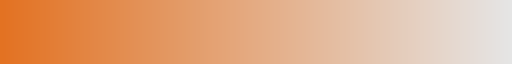

In [4]:
tum_orange_cmap = ColorMaps.orange_tum()
orange_colors = tum_orange_cmap(np.linspace(0,1, 10))
tum_orange_cmap

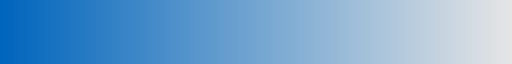

In [5]:
tum_blue_cmap = ColorMaps.blue_tum()
blue_colors = tum_blue_cmap(np.linspace(0,1, 10))
tum_blue_cmap

## Read VW Cell File

In [6]:
path2files = os.path.join(GeneralConfig.path2data.value,"VW","cell")

In [7]:
def filter_func_preprocess_U(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [8]:
def filter_func_preprocess_Q(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [9]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_U)
read_pickle.set_filter_Q(filter_func_preprocess_Q)

In [10]:
df_cell_vw =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_CP_C45.pkl"))

In [11]:
def filter_func(signal):
    perc_filter = 0.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [12]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func)
dva_cell_vw, cap_cell_vw =dva_extractor.get_dva(time=df_cell_vw["time_h"], capacity=df_cell_vw["Q"], voltage=df_cell_vw["U"],crop_cap_Ah=(0,79.5))

In [13]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func)
ica_cell_vw, volt_cell_vw =ica_extractor.get_ica(time=df_cell_vw["time_h"], capacity=df_cell_vw["Q"], voltage=df_cell_vw["U"],crop_volt_V=(2.8,4.2))

## Read VW Vehicle Files

In [14]:
path2files_vw = os.path.join(GeneralConfig.path2data.value,"VW","vehicle")

In [15]:
def filter_func_preprocess_v_U(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [16]:
def filter_func_preprocess_v_Q(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [17]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_v_U)
read_pickle.set_filter_Q(filter_func_preprocess_v_Q)

In [18]:
df_vw =  read_pickle.read(os.path.join(path2files_vw,"VW_ID3_JB_8A_C40_2021.pkl"))
df_vw_aged =  read_pickle.read(os.path.join(path2files_vw,"VW_ID3_JB_8A_C40_2023.pkl"))

In [19]:
df_vw.Q.max()-df_vw_aged.Q.max()

12.90062193447406

In [20]:
def filter_func_v(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [21]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func_v)

In [22]:
dva_vw, cap_vw =dva_extractor.get_dva(time=df_vw["time_h"], capacity=df_vw["Q"], voltage=df_vw["U"],crop_cap_Ah=(1,180))
dva_vw_aged, cap_vw_aged =dva_extractor.get_dva(time=df_vw_aged["time_h"], capacity=df_vw_aged["Q"], voltage=df_vw_aged["U"],crop_cap_Ah=(1,180))

In [23]:
deltaQ_vw =  dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_vw, df_cell = df_cell_vw,n_seriell=108,n_parallel=2)
deltaQ_vw_aged =  dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_vw_aged, df_cell = df_cell_vw,n_seriell=108,n_parallel=2)

In [24]:
# shift aged vehicle to Initial
deltaQ_vw2= dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_vw_aged, df_cell = df_vw,n_seriell=1,n_parallel=1)

In [25]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func_v)
ica_extractor.set_post_filter(filter_func_v)
ica_vw, volt_vw =ica_extractor.get_ica(time=df_vw["time_h"], capacity=df_vw["Q"], voltage=df_vw["U"],crop_volt_V=(360,500))
ica_vw_aged, volt_vw_aged =ica_extractor.get_ica(time=df_vw_aged["time_h"], capacity=df_vw_aged["Q"], voltage=df_vw_aged["U"],crop_volt_V=(364,500))

## Read Tesla Cell File

In [26]:
path2files = os.path.join(GeneralConfig.path2data.value,"Tesla","cell")

In [27]:
def filter_func_preprocess_U(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [28]:
def filter_func_preprocess_Q(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [29]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_U)
read_pickle.set_filter_Q(filter_func_preprocess_Q)

In [30]:
df_cell_tesla =  read_pickle.read(os.path.join(path2files,"Tesla_CATL_161Ah_LFP_20deg_C57.pkl"))

### Tesla Cell DVA/ICA

In [31]:
def filter_func(signal):
    perc_filter = 0.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [32]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func)
dva_cell_tesla, cap_cell_tesla =dva_extractor.get_dva(time=df_cell_tesla["time_h"], capacity=df_cell_tesla["Q"], voltage=df_cell_tesla["U"],crop_cap_Ah=(0,163))

In [33]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func)
ica_cell_tesla, volt_cell_tesla =ica_extractor.get_ica(time=df_cell_tesla["time_h"], capacity=df_cell_tesla["Q"], voltage=df_cell_tesla["U"],crop_volt_V=(2.6,3.6))

## Read Tesla Vehicle Files

In [34]:
path2files_tesla = os.path.join(GeneralConfig.path2data.value,"Tesla","vehicle")

In [35]:
def filter_func_preprocess_v_U(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [36]:
def filter_func_preprocess_v_Q(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [37]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_v_U)
read_pickle.set_filter_Q(filter_func_preprocess_v_Q)

In [38]:
df_tesla =  read_pickle.read(os.path.join(path2files_tesla,"Tesla_JB_8A_CEE7_C57_2021.pkl"))
df_tesla_aged =  read_pickle.read(os.path.join(path2files_tesla,"Tesla_JB_8A_CEE7_C57_2022.pkl"))

In [39]:
df_tesla.Q.max()-df_tesla_aged.Q.max()

5.338256596390863

In [40]:
def filter_func_v(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [41]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func_v)

In [42]:
dva_tesla, cap_tesla = dva_extractor.get_dva(time=df_tesla["time_h"], capacity=df_tesla["Q"], voltage=df_tesla["U"],crop_cap_Ah=(1,180))
dva_tesla_aged, cap_tesla_aged = dva_extractor.get_dva(time=df_tesla_aged["time_h"], capacity=df_tesla_aged["Q"], voltage=df_tesla_aged["U"],crop_cap_Ah=(1,180))

In [43]:
deltaQ_tesla =  dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_tesla, df_cell = df_cell_tesla,n_seriell=106,n_parallel=1)
deltaQ_tesla_aged =  dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_tesla_aged, df_cell = df_cell_tesla,n_seriell=106,n_parallel=1)

In [44]:
# shift aged vehicle to Initial
deltaQ_tesla2= dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_tesla_aged, df_cell = df_tesla,n_seriell=1,n_parallel=1)

In [45]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func_v)
ica_extractor.set_post_filter(filter_func_v)
ica_tesla, volt_tesla = ica_extractor.get_ica(time=df_tesla["time_h"], capacity=df_tesla["Q"], voltage=df_tesla["U"],
                                              crop_volt_V=(280,390),postfilter=True,postfilter_volt_range=(350,360))
ica_tesla_aged, volt_tesla_aged = ica_extractor.get_ica(time=df_tesla_aged["time_h"], capacity=df_tesla_aged["Q"], voltage=df_tesla_aged["U"],
                                                        crop_volt_V=(280,390),postfilter=True,postfilter_volt_range=(350,360))

## Plot

In [46]:
def plot_dva_vw(axes,
                  cap_v, dva_v,
                cap_v_aged, dva_v_aged,
                  shift_factor,
               shift_factor_aged):

    Q_nom = 78
    axes.plot(cap_v+shift_factor,dva_v*Q_nom*2,color=VisualizationConfig.TUMblau.value)
    axes.plot(cap_v_aged+shift_factor_aged,dva_v_aged*Q_nom*2,color=VisualizationConfig.TUMorange.value)
    axes.set_ylabel(r"$Q_{veh.}\ \frac{dU_{veh.}}{dQ_{veh.}}$ in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    axes.set_xlim([0,156])
    axes.set_ylim([0,216])
    tick_positions =np.array([0,54,108,162,216])
    axes.set_yticks(tick_positions)
    tick_positions = np.array([0,40,80,120,156])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    return axes

In [47]:
def plot_dva_tesla(axes,
                  cap_v, dva_v,
                   cap_v_aged, dva_v_aged,
                  shift_factor,
                  shift_factor_aged):

    Q_nom = 161
    axes.plot(cap_v+shift_factor,dva_v*Q_nom,color=VisualizationConfig.TUMblau.value)
    axes.plot(cap_v_aged+shift_factor_aged,dva_v_aged*Q_nom,color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$Q_{veh.}\cdot \frac{dU_{veh.}}{dQ_{veh.}}$ in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    axes.set_xlim([0,106])
    axes.set_ylim([0,81])
    tick_positions =np.array([0,27,54,81,106])
    axes.set_yticks(tick_positions)
    tick_positions = np.array([0,40,80,120,161])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    axes.set_axisbelow(True)
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    return axes

In [48]:
def plot_ica_vw(axes,
                  volt_v, ica_v,
                volt_v_aged, ica_v_aged,):
    
    
    mask_init = ica_v<4.48
    mask_aged= ica_v_aged<4.48
    axes.plot(volt_v[mask_init],ica_v[mask_init],color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_v_aged[mask_aged],ica_v_aged[mask_aged],color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$\frac{dQ_{veh.}}{dU_{veh.}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=9) 
    axes.set_xlim([360,450])
    axes.set_ylim([0,5])
    tick_positions =np.array([0,1,2,3,4,5])
    axes.set_yticks(tick_positions)
    tick_positions = np.array(list(range(360,451,18)))
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    #axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9) 
    
     
    #insert axes left
    axins = axes.inset_axes([408,2.2, 30,2.5],transform = axes.transData) # [x0, y0, width, height]

    axins.plot(volt_v,ica_v,color=VisualizationConfig.TUMblau.value)
    axins.plot(volt_v_aged,ica_v_aged,color=VisualizationConfig.TUMorange.value)

    handles, labels =axins.get_legend_handles_labels()  
    axins.legend(handles=handles,loc="center",fontsize=9,ncols=1,handletextpad=0,title="C",
                 bbox_to_anchor=(435,2.55),  bbox_transform=axes.transData,
            framealpha =1 , fancybox=False,labelspacing=0,columnspacing=0,edgecolor="none",facecolor="none")
    # subregion of the original image
    x1, x2, y1, y2 = 402, 418, 0.8, 1.8
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axes.indicate_inset_zoom(axins, edgecolor="black")
    axins.tick_params('x', top=False, labeltop=False,bottom=False, labelbottom=False)
    axins.tick_params('y', left=False, labelleft=False,right=False, labelright=False)
    axins.annotate(text='', xy=(405,1.7), xytext=(412.5,0.9), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))

    return axes

In [49]:
def plot_ica_tesla(axes,
                  volt_v, ica_v,
                  volt_v_aged, ica_v_aged):
    mask_init = ica_v<175
    mask_aged= ica_v_aged<175
    axes.plot(volt_v[mask_init],ica_v[mask_init],color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_v_aged[mask_aged],ica_v_aged[mask_aged],color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$\frac{dQ_{veh.}}{dU_{veh.}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=9) 
    axes.set_xlim([340,360])
    axes.set_ylim([0,200])
    tick_positions =np.array([0,50,100,150,200])
    axes.set_yticks(tick_positions)
    tick_positions = np.array(list(range(340,361,5)))#np.array([330,356,382])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    #axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    #insert axes left
    axins = axes.inset_axes([344.4,30, 5,80],transform = axes.transData) # [x0, y0, width, height]

    axins.plot(volt_v,ica_v,color=VisualizationConfig.TUMblau.value)
    axins.plot(volt_v_aged,ica_v_aged,color=VisualizationConfig.TUMorange.value)
    handles, labels =axins.get_legend_handles_labels()  
    axins.legend(handles=handles,loc="center",fontsize=9,ncols=1,handletextpad=0,title="A",
                 bbox_to_anchor=(345,95),  bbox_transform=axes.transData,
            framealpha =1 , fancybox=False,labelspacing=0,columnspacing=0,edgecolor="none",facecolor="none")
    
    # subregion of the original image
    x1, x2, y1, y2 = 342, 344.5, 0, 12
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axes.indicate_inset_zoom(axins, edgecolor="black")
    axins.tick_params('x', top=False, labeltop=False,bottom=False, labelbottom=False)
    axins.tick_params('y', left=False, labelleft=False,right=False, labelright=False)
    axins.annotate(text='', xy=(342.3,2.7), xytext=(343.4,11.5), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))

    return axes

In [50]:
def add_FOI_ICA_VW(axes):
    axes.annotate(text='A', xy=(371.5,2.2), xytext=(363.5,2.5),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))   
    axes.annotate(text='B', xy=(394.5,4.5), xytext=(400,4.1),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    # C is annotated in axins
    axes.annotate(text='D', xy=(440,1.5), xytext=(441,2.3),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    #axes.annotate(text='', xy=(363.7,0.4), xytext=(363.7,1.4),fontsize=9,
    #                  arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=5))
    axes.annotate(text='', xy=(446,1.5), xytext=(446,2.5),fontsize=9,
                      arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=5))
    return axes

In [51]:
def add_FOI_ICA_T(axes): 
    # A is annotated in the axins
    axes.annotate(text='B', xy=(353,53.5), xytext=(354,70),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    axes.annotate(text='C', xy=(357,110), xytext=(358,160),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    return axes

In [52]:
def add_FOI_DVA_VW(axes):
 
    Q_nom = 78*2
    #anode
    stage_2_init_dva =np.max(dva_vw[cap_vw>80])
    stage_2_init_cap =cap_vw[dva_vw==stage_2_init_dva]
    
    stage_2_aged_dva =np.max(dva_vw_aged[cap_vw_aged>80])
    stage_2_aged_cap =cap_vw_aged[dva_vw_aged==stage_2_aged_dva] + deltaQ_vw2
    
    axes.scatter(stage_2_init_cap,stage_2_init_dva*Q_nom,marker="d",color=VisualizationConfig.TUMblau.value,s=20,zorder=5,ec="k")
    axes.scatter(stage_2_aged_cap,stage_2_aged_dva*Q_nom,marker="d",color=VisualizationConfig.TUMorange.value,s=20,zorder=5,ec="k")
    
    axes.annotate(text='', xy=(stage_2_init_cap+5,170), xytext=(stage_2_init_cap-5,170),fontsize=9,
                      arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=5)) 
    axes.annotate(text='$\Delta Q_{NE}=1.2Ah$', xy=(stage_2_init_cap-2,180),fontsize=9,ha="center")
    # cathode
    c_init_dva =np.max(dva_vw[(cap_vw>120)&(cap_vw<140)])
    c_init_cap =cap_vw[dva_vw==c_init_dva]
    
    c_aged_dva =np.max(dva_vw_aged[(cap_vw_aged>120)&(cap_vw_aged<130)])
    c_aged_cap =cap_vw_aged[dva_vw_aged==c_aged_dva] + deltaQ_vw2
    
    axes.scatter(c_init_cap,c_init_dva*Q_nom,marker="o",color=VisualizationConfig.TUMblau.value,s=20,zorder=5,ec="k")
    axes.scatter(c_aged_cap,c_aged_dva*Q_nom,marker="o",color=VisualizationConfig.TUMorange.value,s=20,zorder=5,ec="k")
    
    axes.annotate(text='', xy=(c_aged_cap+10+3,140), xytext=(c_aged_cap-10+3,140),fontsize=9,
                      arrowprops=dict(arrowstyle='<-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=5)) 
    axes.annotate(text='$\Delta Q_{PE}=(4.7Ah)$', xy=(c_aged_cap+2,150+2),fontsize=9,ha="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.6))
    
    axes.annotate(text='', xy=(np.max(cap_vw),95), xytext=(np.max(cap_vw)-34,95),fontsize=9,
                      arrowprops=dict(arrowstyle='<-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=5)) 
    axes.annotate(text='$\Delta Q_{B}=13.3Ah$', xy=(np.max(cap_vw)-17,65),fontsize=9,ha="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.6))

    return axes

In [53]:
def add_FOI_DVA_T(axes):
   
    Q_nom = 161
    #anode
    stage_2_init_dva_T =np.max(dva_tesla[(cap_tesla>80)&(cap_tesla<120)])
    stage_2_init_cap_T =cap_tesla[dva_tesla==stage_2_init_dva_T]
    
    stage_2_aged_dva_T =np.max(dva_tesla_aged[(cap_tesla_aged>80)&(cap_tesla_aged<120)])
    stage_2_aged_cap_T =cap_tesla_aged[dva_tesla_aged==stage_2_aged_dva_T] + deltaQ_tesla2
    
    axes.scatter(stage_2_init_cap_T,stage_2_init_dva_T*Q_nom,marker="d",color=VisualizationConfig.TUMblau.value,s=20,zorder=5,ec="k")
    axes.scatter(stage_2_aged_cap_T,stage_2_aged_dva_T*Q_nom,marker="d",color=VisualizationConfig.TUMorange.value,s=20,zorder=5,ec="k")
    
    axes.annotate(text='', xy=(stage_2_init_cap_T+5,62), xytext=(stage_2_init_cap_T-5,62),fontsize=9,
                      arrowprops=dict(arrowstyle='<-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=5)) 
    axes.annotate(text='$\Delta Q_{NE}=0.2Ah$', xy=(stage_2_init_cap_T,67+1),fontsize=9,ha="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.6))
    
    axes.annotate(text='', xy=(np.max(cap_tesla),84), xytext=(np.max(cap_tesla)-20,84),fontsize=9,
                      arrowprops=dict(arrowstyle='<-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=5)) 
    axes.annotate(text='$\Delta Q_{B}=4.7Ah$', xy=(np.max(cap_vw)-11,90),fontsize=9,ha="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.6))
    
    return axes

C:\Users\ga97req\AppData\Local\anaconda3\envs\dva_tool\Lib\site-packages\matplotlib\text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
C:\Users\ga97req\AppData\Local\anaconda3\envs\dva_tool\Lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
C:\Users\ga97req\AppData\Local\anaconda3\envs\dva_tool\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
C:\Users\ga97req\AppData\Local\anaconda3\envs\dva_tool\Lib\site-packages\matplotlib\text.py:566: FutureWarning: Calling float on a single element Series is 

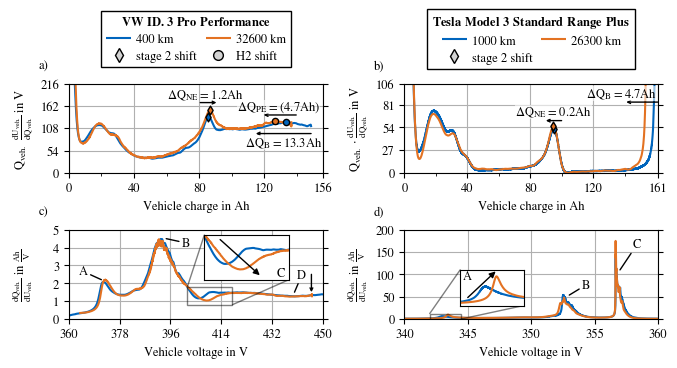

In [54]:
heigth = 5.1 #cm
fig, axes= plt.subplots(2,2,
                        figsize=(VisualizationConfig.textwidth_in_in.value,
                                2 * cm2inch(heigth)))


axes[0][0] = plot_dva_vw(axes = axes[0][0],
                         cap_v = cap_vw, dva_v=dva_vw,
                         cap_v_aged = cap_vw_aged, dva_v_aged=dva_vw_aged,
                         shift_factor =0,
                         shift_factor_aged = deltaQ_vw2)

axes[0][1] = plot_dva_tesla(axes = axes[0][1],
                            cap_v = cap_tesla, dva_v=dva_tesla,
                            cap_v_aged = cap_tesla_aged, dva_v_aged=dva_tesla_aged,
                            shift_factor = 0,
                            shift_factor_aged = deltaQ_tesla2)


axes[1][0] = plot_ica_vw(axes[1][0],
                              volt_v = volt_vw , ica_v = ica_vw,
                              volt_v_aged = volt_vw_aged , ica_v_aged = ica_vw_aged)

axes[1][1] = plot_ica_tesla(axes[1][1],
                            volt_v = volt_tesla , ica_v = ica_tesla,
                            volt_v_aged = volt_tesla_aged , ica_v_aged = ica_tesla_aged)



#Text DVA VW
axes[0,0] = add_FOI_DVA_VW(axes[0,0])
# DVA Tesla
axes[0,1] = add_FOI_DVA_T(axes[0,1])
# ICA VW
axes[1,0] = add_FOI_ICA_VW(axes[1,0])
# ICA Tesla
axes[1,1] = add_FOI_ICA_T(axes[1,1])
#
# legend
#add legend etries
handles, labels =axes[0][0].get_legend_handles_labels()  
line2 = plt.hlines(0,0,1,label=r'400 km', color=VisualizationConfig.TUMblau.value)
line3 = plt.hlines(0,0,1,label=r'32600 km',color=VisualizationConfig.TUMorange.value)
symbol1 = plt.Line2D([0],[0],label=r'stage 2 shift',markerfacecolor="lightgray",markeredgecolor="k",marker="d",color="none",markersize=7)
symbol2 = plt.Line2D([0],[0],label=r'H2 shift',markerfacecolor="lightgray",markeredgecolor="k",marker="o",color="none",markersize=7)
# add manual symbols to auto legend
handles.extend([line2,symbol1, line3,symbol2])
lgd1= axes[0][0].legend(handles=handles,loc="center",fontsize=9,ncols=2,handletextpad=0.4,
           framealpha =1 , fancybox=False,labelspacing=0.4,columnspacing=0.7,edgecolor="black",bbox_to_anchor=(0.5, 1.5),title=r"$\bf{VW\ ID.3\ Pro\ Performance}$",alignment='center')

handles, labels =axes[0][1].get_legend_handles_labels()  
line3 = plt.hlines(0,0,1,label=r'1000 km', color=VisualizationConfig.TUMblau.value)
line4 = plt.hlines(0,0,1,label=r'26300 km',color=VisualizationConfig.TUMorange.value)
# add manual symbols to auto legend
handles.extend([line3,symbol1,line4])
lgd2 = axes[0][1].legend(handles=handles,loc="center",fontsize=9,ncols=2,handletextpad=0.4,
           framealpha =1 , fancybox=False,labelspacing=0.4,columnspacing=0.7,edgecolor="black",bbox_to_anchor=(0.5, 1.5),title=r"$\bf{Tesla\ Model\ 3\ Standard\ Range\ Plus}$",alignment='center')

fig.align_ylabels([axes[0][0],axes[1][0]])
fig.align_ylabels([axes[0][1],axes[1][1]])
plt.tight_layout()

axes[0][0].text(-0.1, 1.2, r'a)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[0][0].transAxes)
axes[0][1].text(-0.1, 1.2, r'b)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[0][1].transAxes)
axes[1][0].text(-0.1, 1.2, r'c)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[1][0].transAxes)
axes[1][1].text(-0.1, 1.2, r'd)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[1][1].transAxes)

fig.savefig(os.path.join(GeneralConfig.path2figures.value,"05-POCV_DVA_ICA_VW_Tesla_aging.pdf"),bbox_extra_artists=(lgd1,lgd2)) 
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"05-POCV_DVA_ICA_VW_Tesla_aging.png"),dpi=300,bbox_extra_artists=(lgd1,lgd2)) 

In [94]:
deltaQ_vw2

0.7494506273972289

In [95]:
deltaQ_tesla2

0.44811715298590266

## DVA Features VW

### total capacity loss

In [96]:
deltaQ_vw2

0.7494506273972289

In [97]:
print(round(np.max(cap_vw),2))

148.86


In [98]:
print(round(np.max(cap_vw_aged),2))

135.96


In [99]:
dQ =round(np.max(cap_vw),2)-round(np.max(cap_vw_aged),2) - round(np.max(deltaQ_vw2),2) #the deltaQ from the shift must also be considered
print(round(dQ,2))

12.15


### VW init anode and balancing features

In [100]:
stage_2_init_dva =np.max(dva_vw[cap_vw>80])
stage_2_init_cap =cap_vw[dva_vw==stage_2_init_dva]

In [101]:
QA_init = round(stage_2_init_cap.values[0],2)
print(round(QA_init,2))

85.72


In [102]:
QB_init = np.max(cap_vw)-QA_init
print(round(QB_init,2))

63.14


### VW aged anode and balancing features

In [103]:
stage_2_aged_dva =np.max(dva_vw_aged[cap_vw_aged>80])
stage_2_aged_cap =cap_vw_aged[dva_vw_aged==stage_2_aged_dva]

In [104]:
QA_aged = round(stage_2_aged_cap.values[0],2)
print(round(QA_aged,2))

86.14


In [105]:
QB_aged = round(np.max(cap_vw_aged)-QA_aged,2)
print(round(QB_aged,2))

49.82


### Feature shift anode and balancing

In [106]:
dQA = round(np.max(QA_init),2) -  round(np.max(QA_aged),2) - round(np.max(deltaQ_vw2),2)
print(round(dQA,2))

-1.17


In [107]:
dQB = round(np.max(QB_init),2) -  round(np.max(QB_aged),2)  # the delta offset is already added in dQA
print(round(dQB,2))

13.32


In [108]:
round(dQA+dQB,2) # apporximately the whole capacity loss, diff of 0.1Ah due to rounding effects

12.15

### VW init cathode features

In [109]:
c_init_dva =np.max(dva_vw[(cap_vw>120)&(cap_vw<140)])
c_init_cap =cap_vw[dva_vw==c_init_dva]

In [110]:
QC_init = round(np.max(cap_vw),2)-round(np.max(c_init_cap),2)
print(round(QC_init,2))

15.43


In [111]:
Q_LLI_init =  round(np.max(QB_init),2)-round(np.max(QC_init),2)
print(round(Q_LLI_init,2))

47.71


### VW aged cathode features

In [112]:
c_aged_dva =np.max(dva_vw_aged[(cap_vw_aged>120)&(cap_vw_aged<130)])
c_aged_cap =cap_vw_aged[dva_vw_aged==c_aged_dva]

In [113]:
QC_aged = round(np.max(cap_vw_aged),2)-round(np.max(c_aged_cap),2)
print(round(QC_aged,2))

9.99


In [114]:
Q_LLI_aged =  round(np.max(QB_aged),2)-round(np.max(QC_aged),2)
print(round(Q_LLI_aged,2))

39.83


### Feature shift cathode

In [115]:
dQC = round(np.max(QC_init),2) -  round(np.max(QC_aged),2)  - round(np.max(deltaQ_vw2),2)
print(round(dQC,2))

4.69


In [116]:
Q_LLI_aged_fixed =  round(np.max(QB_aged),2)-round(np.max(QC_aged),2)+round(np.max(dQC),2)
print(round(Q_LLI_aged_fixed,2))

44.52


In [117]:
false_capacity_loss_due_to_LLI = Q_LLI_init-Q_LLI_aged
print(round(false_capacity_loss_due_to_LLI,2))

7.88


In [118]:
actual_capacity_loss_due_to_LLI = Q_LLI_init-Q_LLI_aged_fixed
print(round(actual_capacity_loss_due_to_LLI,2))

3.19


In [119]:
missing_Q_due_to_v_limits = dQ-actual_capacity_loss_due_to_LLI
print(round(missing_Q_due_to_v_limits,2))

8.96


This is the estimated actual loss of capacity is 3.19 Ah. We assume that if the voltage boundaries were reached further 8.96 Ah are charged into the vehicle.

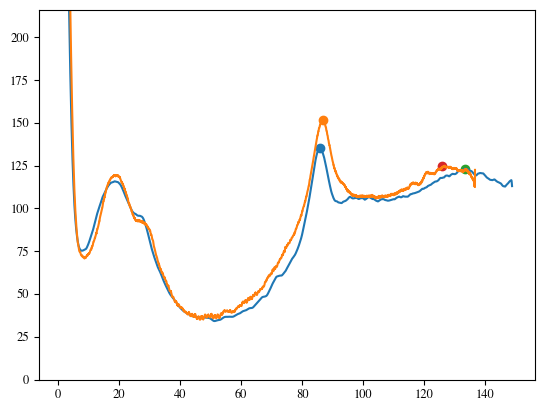

In [120]:
plt.plot(cap_vw,dva_vw*156)
plt.plot(cap_vw_aged+deltaQ_vw2,dva_vw_aged*156)
plt.ylim([0,216])

plt.scatter(stage_2_init_cap,stage_2_init_dva*156)
plt.scatter(stage_2_aged_cap+deltaQ_vw2,stage_2_aged_dva*156)

plt.scatter(c_init_cap,c_init_dva*156)
plt.scatter(c_aged_cap,c_aged_dva*156)

## DVA Features Tesla

### total capacity loss

In [121]:
deltaQ_tesla2

0.44811715298590266

In [122]:
print(round(np.max(cap_tesla),2))

160.79


In [123]:
print(round(np.max(cap_tesla_aged),2))

155.45


In [124]:
dQ_T =round(np.max(cap_tesla),2)-round(np.max(cap_tesla_aged),2) - round(np.max(deltaQ_tesla2),2) #the deltaQ from the shift must also be considered
print(round(dQ_T,2))

4.89


### Tesla init anode and balancing features

In [125]:
stage_2_init_dva_T =np.max(dva_tesla[(cap_tesla>80)&(cap_tesla<120)])
stage_2_init_cap_T =cap_tesla[dva_tesla==stage_2_init_dva_T]

In [126]:
QA_init_T = round(stage_2_init_cap_T.values[0],2)
print(round(QA_init_T,2))

94.79


In [127]:
QB_init_T = np.max(cap_tesla)-QA_init_T
print(round(QB_init_T,2))

66.0


### Tesla aged anode and balancing features

In [128]:
stage_2_aged_dva_T =np.max(dva_tesla_aged[(cap_tesla_aged>80)&(cap_tesla_aged<120)])
stage_2_aged_cap_T =cap_tesla_aged[dva_tesla_aged==stage_2_aged_dva_T]

In [129]:
QA_aged_T = round(stage_2_aged_cap_T.values[0],2)
print(round(QA_aged_T,2))

94.17


In [130]:
QB_aged_T = np.max(cap_tesla_aged)-QA_aged_T
print(round(QB_aged_T,2))

61.28


### Feature shift anode and balancing

In [131]:
dQA_T = round(np.max(QA_init_T),2) -  round(np.max(QA_aged_T),2) - round(np.max(deltaQ_tesla2),2)
print(round(dQA_T,2))

0.17


In [132]:
dQB_T = round(np.max(QB_init_T),2) -  round(np.max(QB_aged_T),2)  # the delta offset is already added in dQA
print(round(dQB_T,2))

4.72


In [133]:
round(dQA_T+dQB_T,2)

4.89